In [72]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier, VotingRegressor

In [73]:
"""Mounting Google Drive"""
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [74]:
folder_path = "/content/drive/MyDrive/Features ASD_TD/"

# Initialize an empty list to store the combined data and labels
data_list = []
labels = []
# Iterate through the ASD and TD folders
for label, folder_name in enumerate(["ASD", "TD"]):
    folder_dir = os.path.join(folder_path, folder_name)

    # Iterate through files in each folder
    for file_name in os.listdir(folder_dir):
        if file_name.endswith(".xlsx"):
            file_path = os.path.join(folder_dir, file_name)
            # Check if the corresponding bands file exists
            bands_file_path = os.path.join(folder_dir, file_name.split('.')[0] + "_bands.xlsx")
            if os.path.exists(bands_file_path):
                # Read both excel files
                df_main = pd.read_excel(file_path)
                df_bands = pd.read_excel(bands_file_path)
                # Combine along columns
                combined_df = pd.concat([df_main, df_bands], axis=1)
                # Append the combined data and label to the list
                data_list.append(combined_df)
                labels.append(label)

In [75]:
combined_df.columns

Index(['Mean', 'Std', 'Median', 'Range', 'Skewness', 'Kurtosis', 'Delta',
       'Theta', 'Alpha', 'Beta', 'Gamma'],
      dtype='object')

In [76]:
np.shape(data_list)

(29, 100, 11)

In [77]:
np.shape(data_list)

(29, 100, 11)

In [78]:
from sklearn.preprocessing import StandardScaler

data_2d = np.asarray(data_list).reshape(-1, np.asarray(data_list).shape[-1])

scaler = StandardScaler()
scaled_data_2d = scaler.fit_transform(data_2d)
data = scaled_data_2d.reshape(np.asarray(data_list).shape)

In [79]:
""" Data Augmentation"""

def augment_data(data, labels, target_samples=1000, noise_factor=0.5):
    augmented_data = []
    augmented_labels = []

    while len(augmented_data) < target_samples:
        idx = np.random.randint(0, len(data))
        original_sample = data[idx]
        original_label = labels[idx]

        noisy_sample = original_sample + noise_factor * np.random.normal(size=original_sample.shape)

        augmented_data.append(noisy_sample)
        augmented_labels.append(original_label)

    augmented_data = np.array(augmented_data)
    augmented_labels = np.array(augmented_labels)

    return augmented_data, augmented_labels

augmented_data, augmented_labels = augment_data(data, labels, target_samples=1000, noise_factor=0.5)

In [80]:
augmented_data = augmented_data.reshape(augmented_data.shape[0], -1)

In [81]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(augmented_data, augmented_labels, test_size=0.2, random_state=42)

In [82]:
gb_model = GradientBoostingClassifier()

In [83]:
gb_model.fit(X_train, y_train)

GradientBoostingClassifier()

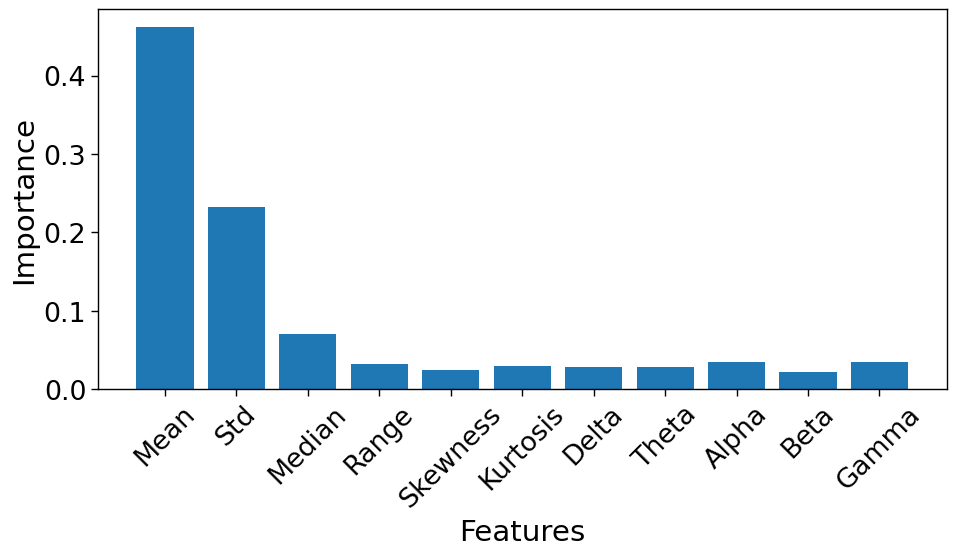

In [84]:
import matplotlib.pyplot as plt

feature_importances = gb_model.feature_importances_
features_names = combined_df.columns  # Assuming combined_df contains the feature names
feature_importances_reshaped = np.array_split(feature_importances, len(features_names))

feature_importances_summed = [np.sum(importance) for importance in feature_importances_reshaped]

plt.figure(figsize=(10, 6))
plt.bar(features_names, feature_importances_summed)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('features_GB.eps', format='eps')
plt.show()

In [85]:
pip install brokenaxes

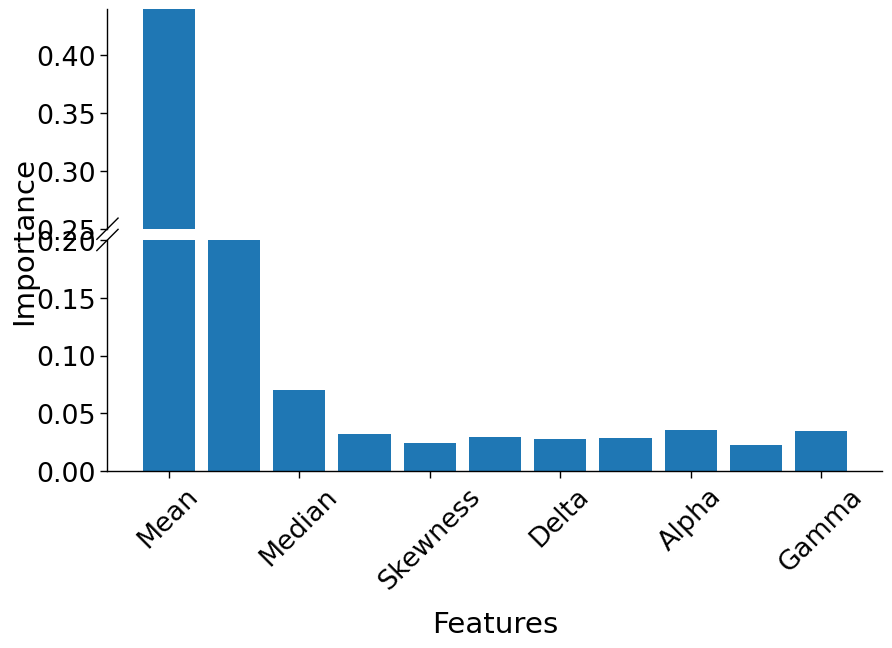

In [86]:
from brokenaxes import brokenaxes

# Create a bar chart with a broken y-axis
fig = plt.figure(figsize=(10, 6))
bax = brokenaxes(ylims=((0, 0.2), (0.25, 0.44)), hspace=.05)  # Adjust ylims based on your data

bax.bar(features_names, feature_importances_summed)
bax.set_xlabel('Features')
bax.set_ylabel('Importance')
bax.tick_params(axis='x', rotation=45)

bax.set_xlabel('Features', labelpad=100)
bax.set_ylabel('Importance', labelpad=50)
bax.tick_params(axis='x', rotation=45)


plt.savefig('features_GB.eps', format='eps', bbox_inches='tight')
plt.show()

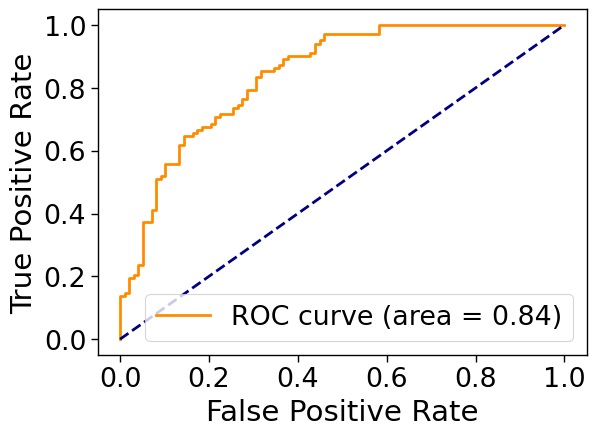

In [87]:
from sklearn.metrics import roc_curve, auc

y_prob = gb_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('roc_GB.eps', format='eps')
plt.show()

In [88]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

y_pred = gb_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Confusion Matrix:
 [[69 29]
 [21 81]]
Accuracy: 0.75
Precision: 0.7363636363636363
Recall: 0.7941176470588235
F1-score: 0.7641509433962265


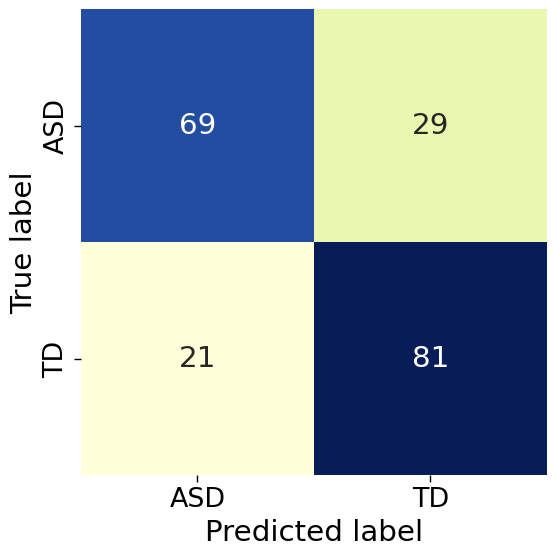

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
# sns.set_context('paper', font_scale=2.2)
sns.heatmap(conf_matrix, annot=True, cmap='YlGnBu', fmt='g',
            xticklabels=['ASD', 'TD'],
            yticklabels=['ASD', 'TD'],
            cbar=False)  # Remove the color bar
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.savefig('conf_GB.eps', format='eps')
plt.show()

In [90]:
from sklearn.metrics import mean_squared_error

y_pred_regression = gb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred_regression)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.25


In [91]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error

""" Time domain features only """

reshaped_data = augmented_data.reshape(1000, 100, 11)
subset1 = reshaped_data[:, :, :6]
subset1_reshaped = subset1.reshape(1000, 600)

X_train, X_test, y_train, y_test = train_test_split(subset1_reshaped, augmented_labels, test_size=0.2, random_state=42)

gb_model.fit(X_train, y_train)


y_pred = gb_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

y_pred_regression = gb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred_regression)
print("Mean Squared Error:", mse)

Confusion Matrix:
 [[65 33]
 [20 82]]
Accuracy: 0.735
Precision: 0.7130434782608696
Recall: 0.803921568627451
F1-score: 0.7557603686635944
Mean Squared Error: 0.265


In [92]:
""" Frequency domain features only """

reshaped_data = augmented_data.reshape(1000, 100, 11)
subset1 = reshaped_data[:, :, 6:11]
subset1_reshaped = subset1.reshape(1000, 500)

X_train, X_test, y_train, y_test = train_test_split(subset1_reshaped, augmented_labels, test_size=0.2, random_state=42)

gb_model.fit(X_train, y_train)


y_pred = gb_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

y_pred_regression = gb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred_regression)
print("Mean Squared Error:", mse)

Confusion Matrix:
 [[64 34]
 [36 66]]
Accuracy: 0.65
Precision: 0.66
Recall: 0.6470588235294118
F1-score: 0.6534653465346535
Mean Squared Error: 0.35
